<h1 style="font-size: 40px">Chapter 12 </h1>

<h1 style="font-size: 30px">Financial Planning Using Reinforcement Learning </h1>

When we looked at asset allocation in earlier chapters, we were essentially performing a single-period optimization. However, most financial planning decisions involve making decisions over multiple periods. And the decisions made today - not only how to allocate assets but how much to spend, whether to claim Social Security, when to retire, what accounts to withdraw from, etc. - affect decisions in the future. These multiperiod, dynamic models, which economists sometimes call “lifecycle models”, are much more complicated to optimize.

In recent years, a branch of Artificial Intelligence called “reinforcement learning” has been applied to a wide range of problems involving decision-making over multiple time periods. Google famously used reinforcement learning to train a computer model to beat the best human at the game Go. Similarly, Libratus used reinforcement learning to beat some of the best poker players. And the successes are not limited to playing games. However, there is currently very little written about using reinforcement learning to solve financial planning problems.
In this chapter, we will explain how reinforcement learning can be used to solve multiperiod wealth management problems. As usual, we will start with a simple example and build up to more realistic, complicated examples.

## 12.1 A Goals-Based Investing Example

In Chapter 5, we used Monte Carlo simulations to answer the question of whether an investor will run out of money in retirement. The simple binary outcome of success or failure is an example of “Goals-Based Investing”. Other examples of goals might be saving for a child's education or saving for a house.

Hopefully, it will be easier to understand the theory behind reinforcement learning with a concrete example in mind. Consider an investor with \\$1 million in assets and a goal of reaching \\$2 million in 10 years. For now, assume there are no savings inflows or spending outflows over the ten years. We would like to compute the optimal asset allocation over time, and the probability of achieving the goal assuming the investor follows the optimal allocation. We assume the asset allocation can change once per year. 

The term “glide path” refers to how the asset allocation changes over time. Conventional wisdom says that the allocation to stocks should decline over time. Indeed, target-date mutual funds are designed to automatically rebalance stock and bond funds over time according to a predetermined glide path. But some authors have suggested an alternative view that equity exposure should increase over time. In this chapter, we will not only compute optimal glide paths, but you will be able to see what factors affect the shape and slope of the glide path. 

This starting example is simplistic and unrealistic on many levels. Perhaps the biggest shortcoming is that the goal is binary and does not make any distinction between achieving a final wealth of \\$2 million and \\$100 million. In reality, of course, even if one dies after the goals are achieved, they still may derive some benefit from knowing they are giving money to charities or children. We can modify the binary goal and use utility functions instead, which will be discussed later in the chapter. We will also discuss adding other choice variables besides asset allocation, like how much to spend each period and when to claim Social Security benefits.


## 12.2 An Introduction to Reinforcement Learning

Reinforcement learning is a branch of machine learning that involves training an agent to make decisions based on trial and error. In this approach, an agent interacts with an environment and receives feedback in the form of rewards or penalties for the actions it takes. In our example, the agent is the investor and the environment is the stock and bond market. The goal of an agent is to learn a policy, which is a set of rules that dictate which actions to take in which situations to maximize the cumulative reward over time.

Just like the way a baby learns to walk, an agent's behavior is shaped by the rewards it receives. Positive rewards encourage the agent to take similar actions in the future, while negative rewards discourage it from doing so. The agent uses this feedback to adjust its policy and improve its decision-making process. 
There are four common features that are used to describe most reinforcement learning problems: state, action, reward, and transition probabilities:

* **State:** A state represents the relevant variables in the environment that affect an agent's actions. In our case, the state will be a tuple containing two variables, wealth, $\small{W}$, and discrete time steps, $\small{t=0,1,2, \ldots , T}$. We will discretize wealth into a finite set of states as well. In Listing 12.1, we create this wealth grid and plot it in Figure 12.1. A few comments are in order. Because the dispersion of potential wealth gets wider over time, our grid has a funnel shape rather than a rectangular shape. We compute a rough maximum and minimum value of wealth over time and then create an equally spaced grid in log of wealth space, which is on the right-hand side of Figure 12.1. The same grid in wealth space is on the left-hand side of Figure 12.1. In Figure 12.1, we only used a wealth grid size of 11 points for illustrative purposes, but when training the model later in the chapter, we substantially increased the grid size.

* **Action:** An action, as the name indicates, is a decision the agent makes that changes the state. In a video game, an action could be moving a joystick to the left or right. In our example, an investor will only be able to invest in a stock fund or a risk-free bond, so an action would be the percentage of wealth that is invested in the stock fund and one minus that percentage is the percentage allocated to the bond. Just like we discretized states, we will discretize actions into 5% increments, so the action space of all possible actions is $\small{A=0\%, 5\%, 10\%, \ldots , 100\%}$. A policy is a mapping from each state to the best action at that state.

* **Rewards:** A reward is a single number that represents the benefit an agent receives after taking an action. The goal of reinforcement learning is to maximize the cumulative rewards over time. A reward can be negative as well, so if the goal is to finish a task as quickly as possible, a negative reward can be assigned for every time step when the task is not completed. In our goals-based investing example, the agent receives a reward of +1 at time $\small{T}$ if his wealth at time $\small{T}$ exceeds the goal, and the agent receives no reward otherwise. We will look at other financial planning problems later in the chapter where the agent receives a reward every period when spending is taken into account.

* **Transition Probabilities:** The transition probabilities define the probabilities of moving from one state at time $\small{t}$ to another state at time $\small{t+1}$ after taking a particular action. An implicit assumption is that only the current state at time $\small{t}$, and not the history of previous states before $\small{t}$, is relevant for computing transition probabilities. This is referred to as the “Markov property”, which is a standard assumption in reinforcement learning problems. In a game of chess, for example, the state would be the positions of the pieces on the board, and the transition dynamics only depend on the current state of the board - the history of how the pieces arrived at that state is irrelevant. In the goals-based investing example, for a given wealth at time $\small{t}$ (the state) and an asset allocation (the action), we can use the mathematics of a normal distribution to compute the transition probabilities of getting to each possible wealth state at time $\small{t+1}$. The Python code for the transition probabilities is given in the next section.


**Listing 12.1 Creating State Space for the Goals-Based Investing Example**

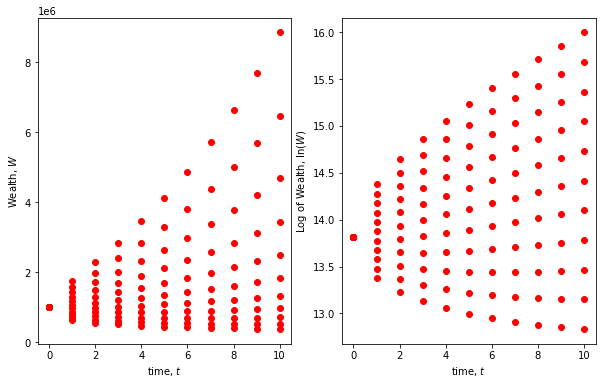

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp

W0 = 1000000
T = 10
nW = 11 #A
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0

lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

for t in range(T+1):
    lnW_min = log(W0) + (mu_stock-0.5*sig_stock**2)*t - 2.5*sig_stock*sqrt(t)
    lnW_max = log(W0) + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW) #B
W = np.exp(lnW)

plt.figure(figsize=(10, 6)) #C
plt.subplot(1,2,1)    
for t in range(T+1):
    plt.scatter(t*np.ones(nW), W[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$")
plt.subplot(1, 2, 2)
for t in range(T+1):
    plt.scatter(t*np.ones(nW), lnW[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Log of Wealth, $\ln(W)$");


#A In the figure below, we used a grid size in wealth of 11, not 101
#B Linear between min and max in log space
#C Plot state spaces

**Figure 12.1. State space in wealth-time and log wealth-time**

Now that we have described the reinforcement learning problem in terms of states, actions, rewards, and transition probabilities, the next step is to estimate the value at each state, which is referred to as the value function. The value function is the expected cumulative rewards, starting from that state. When the value function at each state is maximized, by choosing the best set of actions going forward, then it is the optimal value function. In some cases, a reward today is worth more than a reward in the future, so the value function computes the present value by discounting future rewards. In our case, we only have a reward at the end, so we don't have to deal with discounting, but later we will discuss other financial planning problems involving discounting.
Before we discuss the algorithms used in reinforcement learning, we will digress and discuss an older algorithm to estimate the value function. Reinforcement learning will make more sense when we explain “dynamic programming”, and it will give us a chance to highlight the method's shortcomings and why reinforcement learning has become such a powerful tool.  

### 12.2.1 Solution Using Dynamic Programming

The traditional method for solving our goals-based investment problem was to use dynamic programming (DP) with backward induction (also called backward recursion), which is a technique that has been employed by economists for over 50 years. This method will provide a foundation for understanding reinforcement learning in the next section.

Before we can implement the dynamic programming solution, we need to compute the transition probabilities going from any wealth state at time $\small{t}$ to possible wealth states at time $\small{t+1}$. Listing 12.2 provides the code for estimating the transition probabilities. We start with two helper functions. The first one, `compute_mu_sigma()`, is a simple function that takes an asset allocation and computes the mean and standard deviation of the portfolio. The second helper function, `compute_midpoints()` computes the midpoints of adjacent wealth states. We will estimate the probability of transitioning to a particular discrete wealth state as the probability of wealth falling between the lower and upper midpoints of adjacent wealth states. For the extreme lowest-wealth state, the lower bound is zero wealth, and for the extreme highest-wealth state, the upper bound is infinity. We then compute the cumulative distribution function (CDF) at each midpoint, and the difference between adjacent CDF's is the area under a normal curve, which corresponds to the probability of landing between the midpoints. You may notice an unusual `np.float64()` wrapper when we are computing CDF. The reason is that if we are considering an allocation of 100% risk-free bonds, we would be dividing by zero volatility, which would normally produce an error, rather than +infinity or -infinity, which is what we want. Finally, it should be noted that to get the transition probabilities, Listing 12.2 assumes that stock returns are normally distributed, but we can easily modify the code to incorporate other distributions, like those with fat tails.

**Listing 12.2 Computing Transition Probabilities**

In [22]:
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

def compute_mu_sigma(a):
    mu = a/(nA-1)*mu_stock + (1-a/(nA-1))*mu_bond
    sig = a/(nA-1)*sig_stock
    return mu, sig

def compute_midpoints():
    W_midpoints = np.zeros((nW+1,T+1))
    W_midpoints[0,:] = 0.000001
    W_midpoints[nW,:] = np.inf
    W_midpoints[1:nW,:] = (W[:nW-1,:]+W[1:nW,:])/2
    return W_midpoints

def compute_transition_probs(w, t, a):
    mu, sig = compute_mu_sigma(a)
    W_tplus1_dist = np.zeros(nW)
    cdfs = norm.cdf(np.float64((np.log(W_midpoints[:,t+1]/w) - (mu-0.5*sig*sig))/sig)) #A
    W_tplus1_dist = cdfs[1:nW+1] - cdfs[0:nW] #B
    return W_tplus1_dist

#A Standardize return by subtracting mean and dividing by standard deviation, and then get CDF
#B Probability is the difference in adjacent CDF's

In Figure 12.2, we illustrate the transition probabilities in going from the wealth state at node 54 (just under the \\$2 million goal) in the second-to-last period, $\small{t=9}$, to possible wealth states at time $\small{t=10}$, using the listing above.

<img align="left" width="350" height="750" src="Fig12_2.png">

**Figure 12.2. Transition probabilities from a wealth state at time $\small{T-1}$**

We are now ready to use dynamic programming to compute the optimal value function, and it's only a few lines of code, which is given in Listing 12.3. In our goals-based investing example, we know the value function at the last time period, $\small{T}$. The terminal value is simply the reward at the end, which is +1 if we meet the goal and 0 if we don't. Then, going one step back in time to $\small{T-1}$, we loop through every wealth state. At each wealth state, we then loop through every possible action, or in our case every possible asset allocation, to find the one with the highest expected value. The expected value at a given state and choice of asset allocation is the dot product of the transition probabilities of the future state and the value at those future states. The function $\small{V(W,t)}$ is the optimal value function at each state, and we keep track of the optimal action at each state with the function $\small{A(W,t)}$. Once we find the optimal value at each possible wealth at time $\small{T-1}$, we go back one time step and keep repeating until we get to time step 0.

**Listing 12.3 Dynamic Programming Solution for Goals-Based Investing**

In [23]:
G = 2000000
nA = 21
V = np.zeros((nW, T+1)) #A
A = np.zeros((nW, T)) #B
EV = np.zeros(nA) #C
W_midpoints = compute_midpoints()

for j in range(nW): #D
    if W[j, T] > G: 
        V[j, T] = 1    
        
for t in range(T-1, -1, -1):
    for j in range(nW):
        for a in range(nA):
            W_tplus1_dist = compute_transition_probs(W[j,t], t, a)
            EV[a] = np.dot(W_tplus1_dist, V[:, t+1])
        V[j,t] = EV.max() #E
        A[j,t] = EV.argmax() #F

#A Initialize the two-dimensional optimal value function
#B Initialize the two-dimensional optimal action function
#C Initialize the Expected Value as a function of possible actions
#D Compute the value function in the last time period
#E Save the optimal value for each state
#F Save the optimal action for each state

The optimal value function at any state gives the expected cumulative rewards from that state going forward, and since the reward for “success” is +1 and failure is 0, the value function represents the probability of achieving the goal at any state. For example, at the starting state at $\small{t=0}$ and initial wealth of \\$1 million, the value, $\small{V(0,0)}$ is 0.68, which means there is a 68\% chance of meeting the goal if the optimal policies are followed at each state.
We can also compute the optimal glide path for this problem. Although most financial advice, and target date funds themselves, assume a fixed glide path over time, it should be clear from this example that the optimal asset allocation should not only be a function of time but also a function of wealth. Therefore, it is impossible to talk about the optimal glide path without talking about the path of wealth over time. Out of the trillions of possible paths of wealth, let's consider three simple paths, which are shown in Figure 12.3. In the “good” path, wealth rises by a steady 9\%/year. In the “bad” path, wealth rises by a steady 6\%/year. And in the “medium” path, wealth rises by 7.5\%/year. This is, of course, an oversimplification, but it will illustrate how glide paths can depend on the wealth path.

<img align="left" width="500" height="300" src="Fig12_3.png">

**Figure 12.3. Three paths of wealth**

In Figure 12.4, we show the optimal allocation of stocks for the three wealth paths, which is based on the function $A\small{(W, t)}$ that we computed when we solved the dynamic programming problem. And the results should be fairly intuitive. For all three paths, we start out at time 0 with a fairly high allocation to stocks of 85\%, which is reasonable given our difficult goal of doubling our wealth in 10 years. In the medium return path, the allocation to stocks gradually declines, and at time period $\small{t=9}$, the wealth is large enough that the goal can be achieved with certainty by placing all of the assets in the risk-free bond and there is no reason to take any stock risk, given the reward structure of the problem. In the high return path, the allocation to stocks declines even more rapidly, and by time period $\small{t=7}$, the goal can be achieved by investing in the bond for the remaining time. But in the bad return path, the allocation to stocks goes up as the wealth falls further and further behind in achieving the goal. By time $\small{t=7}$, the best chance the investor has to achieve the goal is to place all assets in stocks and nothing in the bond. This “go-for-broke” risk-taking in the bad path is purely an artifact of how the rewards are specified, and a more realistic objective function can lead to different behaviors, which we will see later.

<img align="left" width="500" height="300" src="Fig12_4.png">

**Figure 12.4. Glide paths for three paths of wealth**

There are two main problems with the dynamic programming method. First, notice that this method requires that we know the transition probabilities in order to compute expected values. There are many problems where the agent does not know the exact model of the environment. Usually in finance applications, we know the dynamics of the environment, but there are situations where it may be difficult to derive closed-form equations for the transition probabilities. However, the more serious shortcoming of DP is related to the curse of dimensionality. In our example, we had a relatively small number of states and possible actions, so the DP solution only took a few seconds to run. But many more realistic wealth problems involve more state variables and states and more potential actions at each state. In the DP solution, we looped through every single state and action to compute the value function. For example, we are including the possibility that wealth can go from an extremely low wealth at time $\small{t}$ to a very high wealth at time $\small{t+1}$, and then back to a very low wealth at time $\small{t+2}$, which is extremely unlikely. In the reinforcement learning algorithm in the next section, we go forward in time rather than backward and we approximate the value function by simulating more likely paths rather than computing the value function exactly by looking at every possible path.

### 12.2.2 Solution Using Q-Learning

Q-learning is one of the most popular algorithms used in reinforcement learning to find optimal policies. At each time step, an agent chooses an action and tries to learn the best policy through these actions. A series of time steps from $\small{t=0}$ to $\small{t=T}$ is called an “episode”, and agents learn by running through many episodes, each time updating their estimate of the value function. With dynamic programming in the last section, we estimated a value function for each state. In Q-learning, we estimate a function $\small{Q}$, which is the value at not only a state but also an action, or a state-action pair. In the goals-based example, we computed $\small{V(W,t)}$. In Q-learning, we will estimate $\small{Q(W,t,a)}$, where a represents an action like an asset allocation. The function $\small{Q}$ is initialized at the beginning, often with all zeros. But instead of starting at time $\small{t=T}$ and going backwards, we go forward in time starting at $\small{t=0}$ and $\small{Q}$ is updated according to the following equation:

$$
\underbrace{Q(S_t,A_t)\vphantom{\max_a}}_{\text{updated }Q\vphantom{\max_a}} \ \  \leftarrow \ \   \underbrace{Q(S_t,A_t)\vphantom{\max_a}}_{\text{current }Q}\  + \underbrace{\ \ \ \ \ \  \alpha\ \ \ \ \ \  \vphantom{\max_a}}_{\text{learning rate}}   \left(\underbrace{\ \ \  R_{t}\ \ \ \vphantom{\max_a}}_{\text{reward}} + \underbrace{\ \ \ \ \ \ \gamma \ \ \ \ \ \ \vphantom{\max_a}}_{\text{discount rate}}  \underbrace{\max_a Q(S_{t+1}, a)}_{\text{optimal next }Q} \ - \ \underbrace{Q(S_t,A_t)\vphantom{\max_a}}_{\text{current }Q} \right)
$$

To better understand this equation let us define a few of the parameters and terms involved in the Q-learning algorithm:

* Optimal next $\small{Q}$: The term $\small{\max_a Q(S_{t+1}, a)}$ is an estimate of the maximum $\small{Q}$ value, over all possible actions, at the next time step, $\small{t+1}$. It is only an estimate of the next period's value, so we are iteratively estimating this period's value based on our estimate of the next period's value.

* Discount rate, $\small{\gamma}$: An agent may prefer immediate rewards over future rewards, and the discount rate 𝛾 represents the rate at which future rewards are discounted $\small{(0<𝛾<1)}$. In the extremes, if $\small{𝛾=1}$, then the agent has no preference for current rewards over future rewards, and if $\small{𝛾=0}$, then the agent is myopic and only cares about immediate rewards. Note that this discount rate can be subjective and differs from the rate of interest. For example, a smoker craving a cigarette may place a large discount on a cigarette received a year from now, and that subjective discount rate can be quite different from the discount rate on a bond.

* Temporal difference (term in brackets): The temporal difference is the difference between the discounted value of future rewards next period, and our estimate of the value this period. If next period's estimate is above our current estimate (a positive difference), we want to increase our current estimate, and vice versa.

* Learning rate, $\small{\alpha}$: The learning rate controls how quickly the agent updates $\small{Q}$ based on the temporal difference.

We are now ready to implement the Q-learning algorithm in Python. We start with the same wealth-time state space grid that was used in the dynamic programming example. In dynamic programming, we had to compute the transition probabilities going from one wealth node at time $\small{t}$ to all possible wealth nodes at $\small{t+1}$. Q-learning is model-free. The agent does not need to know these probabilities, and indeed in some problems we are interested in, these probabilities may be difficult to compute. Therefore, instead of the function in Listing 12.2 that computes transition probabilities, Q-learning will use the function in Listing 12.4 that computes a random transition from wealth at time $\small{t}$ to a new wealth at time $\small{t+1}$.

**Listing 12.4 Generating Random Transition States** 

In [24]:
def transition(w, t, a):
    mu, sig = compute_mu_sigma(a)
    W_tplus1 = w * exp(mu-0.5*sig*sig + sig*np.random.normal())
    W_tplus1_idx = (np.abs(W[:,t+1] - W_tplus1)).argmin() #A
    return W_tplus1_idx

#A Find the closest wealth node next period  that corresponds to the next period's wealth

Listing 12.5 gives the code for updating $\small{Q}$ according to the equation above. One fundamental feature of reinforcement learning that we have not yet addressed is the tradeoff between exploration and exploitation. During the learning process, an agent must choose an action at each state. Exploitation means the agent takes an action that is expected to give the highest reward, based on its current knowledge. In contrast, exploration means the agent takes random actions to learn more about the environment.  Because the agent is still learning, if the agent exclusively took “greedy” exploitative actions, it may miss out on better policies that it hasn't discovered yet. On the other hand, if the agent exclusively explored with random actions, it would be completely discarding useful knowledge, and the time to find the optimal solution would be very slow. A common strategy to balance exploration and exploitation is an epsilon-greedy method, where the agent explores a random action with probability $\small{\epsilon}$ and chooses the action with the highest expected cumulative reward, $\small{Q(W,t,a)}$, with a probability $\small{1-\epsilon}$. The simple epsilon-greedy strategy is implemented in Listing 12.5, although there are many more sophisticated approaches. For example, an agent could start off with a higher exploration rate and gradually reduce that rate as it learns more. Or, rather than exploring by indiscriminately choosing a random action, an agent can draw an action based on a probability distribution derived from the $\small{Q}$ values for each action, exploring actions that are more likely.

**Listing 12.5 Updating Q**

In [25]:
def Update_Q(w_idx, t, Q):
    if np.random.uniform() < epsilon: #A
        a = np.random.randint(nA)
    else:
        A_array = Q[w_idx, t, :]
        a = np.where(A_array == A_array.max())[0]
        if (len(a)>1): #B
            a = np.random.choice(a)
    W_tplus1_idx = transition(W[w_idx,t], t, a)
    Q[w_idx, t, a] += alpha*(gamma*Q[W_tplus1_idx, t+1, :].max() - Q[W_idx, t, a]) #C
    return W_tplus1_idx, t+1, Q

#A Explore with a probability epsilon
#B If more than one action has the same Q, choose one of them randomly
#C This implements the Q-Learning update equation that was discussed in the text

The final step in reinforcement learning is to generate thousands of episodes, or paths, to learn the function $\small{Q}$, and consequently the optimal actions at each state. It has been proven mathematically that if the number of episodes approaches infinity, Q-learning will converge to the optimal policy. Listing 12.6 gives the Python code for generating paths. We initialized $\small{Q}$ the same way we initialized $\small{V}$ in the dynamic programming section by assigning a +1 or 0 depending on whether the final wealth at time $\small{t=T}$ is greater than the goal, although for Q-learning this is unnecessary - we could have initiated the terminal values of $\small{Q}$ to zero and the algorithm would have learned the terminal values. Also, notice that we added a progress bar using the `tqdm` library so that users can monitor the progress of the reinforcement learning algorithm and get an estimate of how long it will take to complete. Once the algorithm in Listing 12.6 is finished running on thousands of episodes, it is easy to see that the optimal policies and values from reinforcement learning should come close to those from dynamic programming.

**Listing 12.6 Generating Episodes**

In [28]:
from tqdm import tqdm

n_episodes = 1000000
epsilon = 0.5
alpha = 0.1
gamma = 1.0

Q = np.zeros((nW, T+1, nA))
for j in range(nW):
    if W[j, T]>G:
        Q[j, T, :] = 1

for i in tqdm(range(n_episodes), desc="Running..."):
    W_idx = 0
    t = 0
    while t<=(T-1):
        W_idx, t, Q = Update_Q(W_idx, t, Q)

Running...: 100%|██████████████████████████████████████████████████████████| 1000000/1000000 [06:06<00:00, 2726.48it/s]


We mentioned several shortcomings in the goals-based investing example. For example, because of the binary reward of success or failure, all successes and failures count the same and the magnitude of success or failure is irrelevant. As a result, in low-wealth states, investors become extremely risk loving and will take huge risks in a desperate attempt to achieve their goal, and in high-wealth states, investors are indifferent between having \\$2 million and \\$20 million and become extremely risk-averse once their goal can be achieved with certainty. One could argue that this is a flaw, or oversimplification, of the binary objective function we used. And other objective functions have their own flaws. For example, if the objective is to maximize final period wealth, an investor will act as if he's risk neutral and allocate as much as possible to higher expected-return stocks, regardless of risk. A potential solution is to use utility functions in the objective function, which is the next topic.

## 12.3 Utility Function Approach

Economists have long used utility functions to quantify the enjoyment people derive from wealth or consumption. With a few exceptions, financial planners have not adopted utility functions in financial planning and decision-making. In this section, we will show how this area of economics can be applied to reinforcement learning, but first, we will explain what utility functions are.

### 12.3.1 Understanding Utility Functions

Suppose we wanted to define a utility function that represents how much pleasure an individual derives from different levels of wealth. Let's first think about what shape this function would take. We know that people prefer more wealth to less wealth, so the function would be upward-sloping. It is also reasonable to assume that the more wealth you have, the less happiness you'll derive from an additional dollar of wealth. In other words, if you're wealth is \\$1 and you find \\$10 under your couch, you will be happier than if you have \\$1 million and find $10, just like if you are hungry, the pleasure you get from the first scoop of ice cream is greater than the pleasure you would get from an additional scoop after you've already had 10 scoops. This is the principle of diminishing marginal utility and leads to a utility function that has a concave shape. An example of a concave utility function is shown in Figure 12.5.

<img align="left" width="500" height="300" src="Fig12_5.png">

**Figure 12.5. Upward sloping concave utility function**

A concave utility function also implies the individual is risk averse. To see that, suppose an individual wins a prize, determined by a coin flip. If he guesses correctly, he gets \\$10 million, and if he guesses incorrectly, he gets zero. He would much prefer to have a certain \\$5 million rather than participate in the coin flip. In fact, you can compute the “certainty equivalent” value of this prize. For the utility function in Figure 12.6, the certainty equivalent amount is \\$2.5 million, which means he would be indifferent between a sure \\$2.5 million and the coin flip between zero and \\$10 million. The degree of risk aversion is related to the curvature of the utility function. An individual with a straight-line utility function would be risk neutral rather than risk-averse.

<img align="left" width="500" height="300" src="Fig12_6.png">

**Figure 12.6. Certainty Equivalent value of a coin flip**

One utility function that is commonly used by economists is called the power utility function, which is given by the equation

$$U(W) = \frac{W^{1-\eta}}{1-\eta} \text{ for } \eta\ge 0, \eta \ne 1$$

The constant $\small{\eta}$ is referred to as the coefficient of Constant Relative Risk Aversion (CRRA). When $\small{\eta=0}$, the utility function is linear, which corresponds to risk neutrality. When $\small{\eta \to \infty}$, the utility function represents extreme risk aversion. And when $\small{\eta = }$, the utility function is defined as $\small{U(W) = ln(W)}$. One of the challenges of using utility functions is estimating $\small{\eta}$, which varies by individual, and the challenge is not dissimilar to the challenge of mapping risk tolerance surveys to an asset allocation that we discussed in Chapter 2. There have been dozens of empirical studies in the Economics literature that have tried to estimate $\small{\eta}$, using lab experiments, surveys, auction behavior, labor supply behavior, insurance choices, and options prices. There are even several papers that try to estimate the parameters from the behavior on game shows like “Who Wants to Be a Millionaire” and “Deal or No Deal”. The range of estimates varies, and in the examples below, we will use a coefficient of $\small{\eta = 3}$.

Now that we’ve explained utility functions, let’s see how they can be used in financial planning and decision-making. A simple extension of the goals-based investing example is to replace the binary reward of +1 or 0 with the utility of final wealth, $\small{U(W_T)}$. This involves changing a single line of code: in the dynamic programming solution, the line of code that initializes the terminal value function, and in the Q-learning solution, the line of code that initializes $\small{Q}$ with the final reward. But in the next section, we will consider a more complex extension, involving optimal spending.

### 12.3.2 Optimal Spending Using Utility Functions

In the goals-based investing example, the only action an agent takes at each state is choosing the percentage of stock holdings. Spending, an important consideration for financial planning, was completely ignored. We touched upon spending in Chapter 5 on Monte Carlo simulations. But in Chapter 5, when we tried to estimate how long an individual's money would last, we either assumed spending was fixed each year, or we adjusted it in a very simple way through guardrails, with no attempt at optimization. In this section, we will try to optimize how to choose spending each year as a function of an individual's wealth-time state to maximize expected utility, simultaneously optimizing asset allocation as well. 

This is a classic problem in financial economics, which you can find in a Google search for “optimal consumption and portfolio choice”. We will discuss later the difference between what economists call “consumption” and what financial planners and everyone else call “spending”, but for now, assume they are the same. Under some assumptions, there is a mathematical solution and numerical solutions are unnecessary. However, when we add additional assumptions later, it can only be solved numerically. The mathematical description of the problem is

$$
\begin{equation*}
\begin{aligned}
& \underset{\large{a_t, \ c_t}}{\text{max}} & & E \left[ \sum_{t=0}^T \gamma^t U(c_t) \right] \\
& \text{subject to} & & W_{t+1} = (W_t - c_t) \ (a_t {\tilde{r}_t} + (1-a_t) r_f)
\end{aligned}
\end{equation*}
$$

where $\small{a_t}$ is the allocation to stocks, $\small{c_t}$ is consumption, $\small{W_t}$ is wealth, $\small{\tilde{r}_t}$ is the random return on the stock portfolio, $\small{U(c_t)}$ is the utility of consumption, all at time $\small{t}$, and $\small{\gamma}$ is the subjective discount factor. The reward for each period is the utility of consumption, and we want to maximize the cumulative sum of discounted rewards. But we need a budget constraint, which shows how wealth evolves over time and places a constraint on spending. The next period's wealth is equal to this period's wealth, net of consumption this period, plus investment income. Labor income could also be included in the budget constraint, which we'll address later in the chapter.

The code for solving this problem is very similar to the code for the goals-based investing problem. We will provide the code below and highlight the lines of code that change when we introduce utility functions and spending. As before, we start with creating a state space grid, which is shown in Listing 12.7. With spending, the state space grid will be slightly different from the original Listing 12.1 - the lower bound must be lower to account for lower wealth states after consumption depletes wealth.

**Listing 12.7 Creating State Space for the Spending Example**

In [29]:
W0 = 1000000
T = 10
nW = 101
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0

Cbar = np.zeros(T+1)
Cbar[0] = 0
for t in range(1, T+1):
    Cbar[t] = Cbar[t-1] + 1/(T-t+1)

lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

for t in range(T+1):
    lnW_min = log(W0) - t*log(3) #A
    lnW_max = log(W0) - Cbar[t] + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW)
W = np.exp(lnW)

#A The potential minimum wealth is lower because of consumption 

The dynamic programming code in Listing 12.8 has a few key differences from the corresponding code in Listing 12.3. Now, we cannot ignore the subjective discount rate, gamma, since the agent receives rewards every period from consumption. In the last period, all wealth is consumed so we set the value function at time $\small{T}$ equal to the utility of final wealth, $\small{U(W_T)}$. We not only have to loop through every wealth-time state and every discrete asset allocation, but now we also loop through every discrete level of consumption. In our example, consumption is a percentage of wealth ranging from 1.66\%, 3.33\%, … , 66.67\%. When computing the transition probabilities emanating from wealth at time $\small{t}$, we must subtract the consumption at time $\small{t}$ now. And the calculation of the expected value at a node has an extra term: the (discounted) value next period, as before, but the current reward, which is the utility of consumption this period. 

**Listing 12.8 Dynamic Programming Solution for  Spending Example**

In [30]:
nA = 11
nC = 40
V = np.zeros((nW, T+1))
A = np.zeros((nW, T))
C = np.zeros((nW, T)) #A
EV = np.zeros((nA, nC))
W_midpoints = compute_midpoints()

gamma = 0.95 #B
CRRA = 3 #C
def utility(c): #D
    if (CRRA == 1):
        util = log(c)
    else:
        util = (c**(1-CRRA))/(1-CRRA)
    return util

for j in range(nW):
        V[j, T] = utility(W[j,T]) #E 
        
for t in range(T-1, -1, -1):
    for j in range(nW):
        for a in range(nA):
            for c in range(nC):
                cons = (c+1)/(1.5*nC)*W[j,t] #F
                W_tplus1_dist = compute_transition_probs(W[j,t]-cons, t, a) #G
                EV[a,c] = np.dot(W_tplus1_dist, utility(cons)+gamma*V[:,t+1]) #H
        V[j,t] = EV.max()
        A[j,t], C[j,t] = np.unravel_index(EV.argmax(), EV.shape) #I

#A Initialize the two-dimensional optimal consumption
#B The subjective discount rate
#C The coefficient of constant relative risk aversion
#D Power utility function
#E In the last period, all wealth is consumed
#F Consumption is a percentage of wealth
#G Consumption is subtracted from wealth before computing the transition probabilities
#H Current value is utility from consumption plus discounted expected value next period
#I Returns the row (asset allocation) and column (consumption) for optimal solution

For the reinforcement learning solution with spending, the code in Listing 12.4 that computes a random transition from wealth at time $\small{t}$ to a new wealth at time $\small{t+1}$ does not change, since we already accounted for consumption in the starting wealth. In Listing 12.9, the function that implements an epsilon-greedy strategy for updating $\small{Q}$ is very similar to the code in Listing 12.5. The code that updates $\small{Q}$ now includes the current reward, which is the utility of current consumption.

**Listing 12.9 Updating Q for Spending Problem**

In [31]:
def Update_Q(w_idx, t, Q):
    if np.random.uniform() < epsilon:
        a = np.random.randint(nA)
        c = np.random.randint(nC)
    else:
        AC_array = Q[w_idx,t,:,:]
        ac = np.argwhere(AC_array == AC_array.max()) #A
        if (len(ac)>1):
            a,c = ac[np.random.choice(len(ac))]
        else:
            a,c = ac[0]
    cons = (c+1)/(1.5*nC)*W[w_idx,t]
    W_tplus1_idx = transition(W[w_idx,t]-cons, t, a) #B
    Q[w_idx,t,a,c] += alpha*(utility(cons) + gamma*Q[W_tplus1_idx,t+1,:,:].max() -
                                                   Q[W_idx,t,a,c]) #C
    return W_tplus1_idx, t+1, Q

#A Row (asset allocation) and column (consumption) of highest Q
#B Consumption is subtracted from wealth before computing random next state
#C This implements the Q-Learning update equation that was discussed in the text, including current consumption

Finally, generating episodes in Listing 12.10 is identical to the code in Listing 12.6 except that $\small{Q}$ is initialized at $\small{t=T}$ to the utility of consuming all the wealth, and we also increased the number of episodes to reflect the fact that we have a larger space of possible actions to choose with both consumption and asset allocation.

**Listing 12.10 Generating Episodes for Spending Problem**

In [32]:
from tqdm import tqdm

n_episodes = 5000000
epsilon = 0.5
alpha = 0.1
gamma = 0.95

Q = np.zeros((nW, T+1, nA, nC))
for j in range(nW):
        Q[j,T,:,:] = utility(W[j,T]) #A

for i in tqdm(range(n_episodes), desc="Running..."):
    W_idx = 0
    t = 0
    while t<=(T-1):
        W_idx, t, Q = Update_Q(W_idx, t, Q)

#A Initialize Q in the final time period to the utility of final wealth

Running...: 100%|██████████████████████████████████████████████████████████| 5000000/5000000 [35:35<00:00, 2341.02it/s]


As you might guess from the objective function, spending is optimized when consumption is smoothed over time. It would not be wise to spend a large amount of wealth early on, giving a high reward now but a low reward in the future. For example, at the second to last time period, $\small{t=T-1}$, you would want to spend approximately half your wealth, saving the other half for the last time period. Also, if you adjust the parameters of the model, you can see the effects on spending:

* Higher expected returns lead to more spending today because you have higher expected wealth next period for consumption smoothing (for those interested in that relationship, you can explore the Euler Equation on `github.com/robreider/robo-advisor-with-python/Chapter-12.ipynb`).
* Higher degrees of risk aversion leads to more savings and less spending today. 
* Higher subjective discount rates, which measure the preference for immediate consumption, of course, lead to more spending today.

One of the largest shortcomings of the model we described in this section is that the agent knows he has exactly $\small{T}$ years to live. For example, because of that highly unrealistic assumption, the agent can safely spend approximately half his wealth at $\small{t=T-1}$ knowing that he will have the other half for the last year. In the next section, we will extend the model to include mortality tables which will allow us to solve a richer set of financial planning problems.

## 12.4 Longevity Risk

The uncertainty in life expectancy has an enormous impact on financial planning. Individuals not only face stock market risk but also the risk that they outlive their assets, which is referred to as longevity risk. Despite the importance of longevity risk, most financial planning tools are not equipped to handle it. We mentioned in Chapter 1 that a vast majority of Social Security calculators compute the present value of Social Security payments, which is essentially a risk-neutral approach. These calculators suggest claiming Social Security later if the life expectancy of an individual exceeds the break-even age. 

Using lifecycle models with utility functions is a significant improvement over these other techniques for handling longevity risk. And only a few lines of code need to be changed to incorporate an uncertain date of death. We won’t repeat the code again, but it can be found in `github.com/robreider/robo-advisor-with-python/Chapter-12.ipynb`.

Consider a 62-year-old individual who is deciding whether to claim Social Security right away at 62 vs waiting until 70 to take a 76\% higher payout. Using the mortality tables from Chapter 5, the life expectancy for a 62-year-old is about 84 years old, which is a little above the break-even age, suggesting that it's better to delay claiming Social Security. But it's a close call, and the present value of claiming at 70 is only about \\$3,000 more than claiming at 62. However, when we take into account longevity risk, it's not such a close call. The utility for claiming at 70 is significantly higher than the utility for claiming at 62. But how can we translate the difference in utility to something meaningful, like dollars? We can use the concept of certainty equivalence that we discussed earlier in the chapter. For the individual who claims at 62, we can incrementally increase his starting wealth from \\$1mm and stop when his utility equals the utility of the person who claims at 70. That number is \\$35,000 for someone with a coefficient of relative risk aversion of 3. To put that number in perspective, the \\$35,000 extra for claiming later is more than a year's worth of Social Security payments. In Figure 12.7, we show the higher values for claiming Social Security at 70 for three levels of risk aversion. As you would expect, the higher the risk aversion, the greater the value of waiting to claim Social Security.

<img align="left" width="500" height="300" src="Fig12_7.png">

**Figure 12.7. Quantifying the benefit of claiming Social Security at 70 vs 62**

We made several assumptions in this analysis, and the differential between claiming Social Security at 70 vs 62 will vary, depending on the assumptions. Here are a few of these critical assumptions:
* We used the mortality tables from the Society of Actuaries that were described in Chapter 5. Of course, if life expectancies are shorter than the average life expectancy, then the benefit of delaying is reduced.
* We assumed a real rate of interest (the difference between the nominal rate of interest and inflation) of 2\% (4.5\% bond return and 2.5\% inflation rate). Since Social Security payments grow with inflation, inflation rate assumptions by themselves would not necessarily affect the claiming decision, but the difference between nominal rates and inflation would. For example, if we assumed a real rate lower than 2\%, then the benefit of delaying is even greater.
* We only considered the optimization from the perspective of an individual, not a married couple. For example, if your spouse had a short earnings history, they can receive spousal and survivor benefits based on your work history. Although delaying claiming will not increase the spousal benefit, it will increase the survivor benefit if you die before your spouse, which further increases the benefit of delaying.

The same type of analysis we employed here can be used to answer other financial planning questions. For example, many employees with defined benefit pension plans must choose between taking their payout as a lump sum or a steady stream of lifetime income. We can use the same lifecycle model to analyze this decision, with some small modifications (for example, pension payments typically don’t have inflation adjustments). Another similar financial planning decision individuals face is whether to purchase annuities from an insurance company. In fact, because of provisions in the Secure Act that was passed in 2019, many more 401(k) plans are offering annuities as an option. These annuities reduce longevity risk but often come with high fees. The type of annuities offered may also vary, ranging from annuities that start paying income immediately to deferred annuities that delay income payments. The lifecycle models we described can be used to analyze the various options and can be customized to an individual’s circumstances. 

## 12.5 Other Extensions

There are numerous ways to make the model even more realistic, and even though we will leave it up to the reader to explore, we will give a few examples to conclude this chapter. Here is a list of a few things to consider for extending the model, but this is not meant to be an exhaustive list:

* We did not include labor income during the accumulation phase of an individual’s life cycle. Empirical studies show that spending is highly correlated to labor income. And uncertainty in future labor income leads to more “precautionary savings”. Similarly, we did not include medical expenses, which are also uncertain and may be treated separately from other types of consumption: usually medical expenses are treated as necessary costs and no utility is derived from them.
* Although taxes have been discussed in other chapters, we have not incorporated them into the reinforcement learning model. For example, we have simply assumed that money for spending comes from wealth, without considering the tax implications and the optimal sequence of withdrawals, which is discussed in Chapter 14.
* We have assumed spending and consumption are the same thing. But economists distinguish spending on non-durable goods, which are immediately consumed, from spending on durable goods. Consider, for example, a house as a durable good.  Economists argue that only a small percentage of the value of a house is “consumed”, in the form of housing services, which would be the imputed rent on an owner-occupied home, or in other words, the rent they would pay on an equivalent house. Also, an individual can’t increase their housing services by 1% if they get a little wealthier, because upgrading from a smaller house to a larger house involves significant transaction costs and can’t be incrementally modified like a stock or bond holding.
* There is extensive literature on alternatives to the utility function that we used. For example, prospect theory, developed by behavioral economists Kahneman and Tversky, posits that losses have a greater emotional impact than equivalent gains, leading to an asymmetric utility function around some reference point, like current wealth or spending.
* We have ignored the “bequest motive” and assumed the agent receives no reward for any money he passes down to his heirs. It is straightforward to capture the bequest motive by adding an extra reward upon death that is a function of the wealth that is passed down. And economists have tried to estimate a constant representing the utility one derives from passing a dollar to heirs compared to the utility from consuming that dollar.

## Summary
In this chapter we have learned:
* Reinforcement learning, a branch of AI, has been successfully applied to many tasks and can be applied to multiperiod financial planning problems as well 
* Goals-based investing involves strategies for achieving a savings goal, such as saving a certain amount for retirement or for buying a home
* The traditional approach to finding the optimal asset allocation over multiple periods is to use dynamic programming, working backwards from the terminal state
* The advantage of reinforcement learning over dynamic programming is that you don’t need to know the probability distribution of transitioning to the next state, and dynamic programming suffers from the curse of dimensionality when there are too many states and potential actions 
* The glide path, which is the optimal allocation of stocks over time, can take many shapes depending on the wealth path
* Using utility functions has not been widely adopted by financial planners but is a useful tool for handling financial planning decisions involving risk
* Spending and asset allocation can simultaneously be optimized using reinforcement learning
* The risk of outliving one’s assets because of uncertainty in life expectancy is referred to as longevity risk and is generally not properly captured with existing financial planning tools
* Reinforcement learning that incorporates mortality tables can be used to answer financial planning questions like when to claim Social Security, whether to choose a lump sum pension payout, and whether to buy an annuity
* When longevity risk is properly accounted for, the benefit of receiving payments for life is much larger than a simple break-even analysis would suggest
* The models can easily be extended in many directions, by including labor income and health expenses, taxes, housing decisions, a bequest motive, and alternate utility functions